# 9. CHAOS - Lorenz Equations

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root, fsolve, curve_fit
from scipy.misc import derivative
import scipy.linalg as lg
# PDF = Probability Distribution Function (smooth Histogram)
from scipy.stats import gaussian_kde as PDF  
# find maximas (peaks) in a list
from scipy.signal import find_peaks

import sympy as sp
import fractions as fra

# install the tabulate module using: "conda install tabulate"
from tabulate import tabulate

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Utility functions

In [4]:
# chop(expr) = 0 if |expr| < delta
def chop(expr, delta=10**-10):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)


In [5]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,col='k',title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)

    fig, ax=plt.subplots(figsize=(6,4))
    ax.contour(R,X,Zs,levels=[0],colors=col,linewidths=3)
    ax.contour(R,X,Zu,levels=[0],colors=col,linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()    

In [6]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

# Phase portrait: streamlines through selected points + nullclines
def PP_2d_sp_nc(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Display fixed points
def PP_FPs(FPs,tau,delta,ax):
    ax = ax or plt.gca()
    for j in np.arange(len(FPs)):
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            print('stable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            print('unstable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    return ax

In [7]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FP evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

In [8]:
# functions to calculate trajectory {x(t),y(t)} numerically for given {x0,y0} 
# input: functions f1,f2; duration T and timestep dt of trajectory; initial condition xy0=[x0,y0]
# output: [t,sol] = [t,[x(t),y(t)]]

def txy_traj(f1,f2,T,dt,xy0):
    t = np.arange(0,T+dt,dt)
    def RHS(xy,t):
        x,y=xy
        return[f1(x,y),f2(x,y)]
    sol = odeint(RHS,xy0,t)
    return [t,sol]

In [9]:
# functions to solve LE  
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_LE(sigma,r,b,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[sigma*(y-x),r*x-y-x*z,x*y-b*z]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

## Lorenz Equations (LE)

The Lorenz equations (LE) represent a 3D dynamical system that defines a simplified toy-model of convection rolls in the atmosphere. The dynamical variables are $x$, $y$ and $z$, and the system has three _positive definite_ model parameters $\sigma$, $r$ and $b$. 

The LE are
\begin{eqnarray}
\dot{x} &=& \sigma (y-x) \nonumber \\
\dot{y} &=& r x-y-xz  \nonumber \\
\dot{z} &=& xy-b z   \nonumber
\end{eqnarray}

For certain values of the parameters the dynamics is ___chaotic___, with the following characteristics

- the trajectory is _aperiodic_ but bounded in the phase space

- as $t\rightarrow\infty$, the trajectory approaches a _strange attractor_

- the strange attractor is a _fractal_, with _fractional dimension_ $d\in(2,3)$

## Solution of the LE for  $\sigma=8$, $r=28$ and $b=8/3$

In [10]:
# set parameter values
s0, r0, b0 = 8, 28, 8/3
r_H = s0*(s0+b0+3)/(s0-b0-1)
c0 = np.sqrt(b0*(r0-1))
Cp0= [c0,c0,r0-1]; Cm0=[-c0,-c0,r0-1]
print('r_H = ',np.round(r_H,2),'<',r0)
print('C_+ = ',np.round(Cp0,2),';  C_- = ',np.round(Cm0,2))
# define duration (T) and time-step (dt) and initial conditions (xyz0)
T=50; dt=0.01
xyz0 = [15,5,-10]
xyz1 = [1,1,1.001]

r_H =  25.23 < 28
C_+ =  [ 8.49  8.49 27.  ] ;  C_- =  [-8.49 -8.49 27.  ]


In [11]:
# Integrate numerically the LE 
t, xyz = txyz_LE(s0,r0,b0,T,dt,xyz0)
t, xyz1= txyz_LE(s0,r0,b0,T,dt,xyz1)

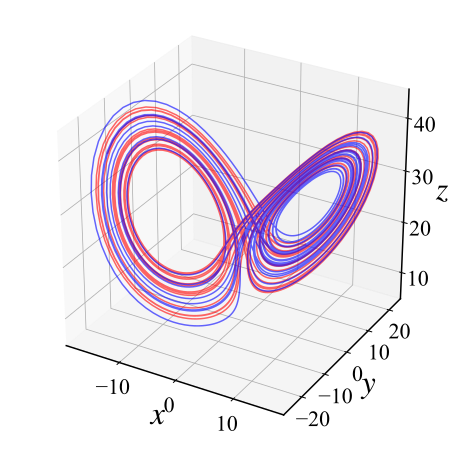

In [18]:
# Plot the 3D trajectory for t0<t<T
t0=25; t0_=int(t0/dt)
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False

fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection':'3d'})
ax.plot(xyz[t0_:,0],xyz[t0_:,1],xyz[t0_:,2],'r',alpha=0.6)
ax.plot(xyz1[t0_:,0],xyz1[t0_:,1],xyz1[t0_:,2],'b',alpha=0.6)
ax.set_xlabel('$x$', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_zlabel('$z$', fontsize=32)
# plt.savefig('FIGS/Lorenz.pdf')
plt.show()

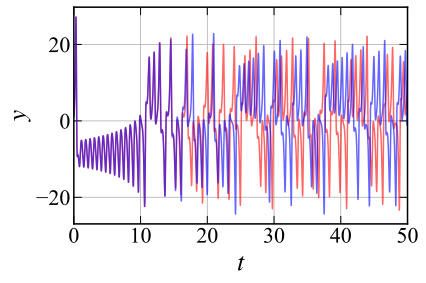

In [19]:
# Plot the y-t [0<t<T]
fig_yt, ax = plt.subplots(figsize=(6,4))
ax.plot(t, xyz[:,1],'r-',alpha=0.6)
ax.plot(t,xyz1[:,1],'b-',alpha=0.6)
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
ax.grid()
ax.set_xlim(0,T)
# plt.savefig('FIGS/LE-yt.pdf')
plt.show()

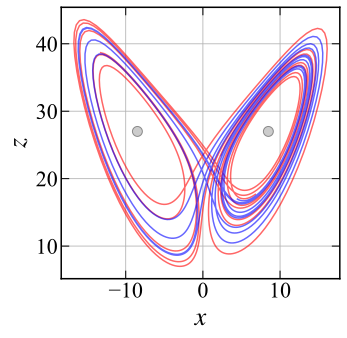

In [20]:
# Plot the x-z projection of the 3D trajectory [0<t<T]
t0 = int(40/dt)
fig_xz, ax = plt.subplots(figsize=(5,5))
ax.plot( xyz[t0:,0],xyz[t0:,2],'r-',alpha=0.6)
ax.plot(xyz1[t0:,0],xyz1[t0:,2],'b-',alpha=0.6)
ax.plot(Cp0[0],Cp0[2],'o',ms=10,mec='k',mfc='gray',alpha=0.4)
ax.plot(Cm0[0],Cm0[2],'o',ms=10,mec='k',mfc='gray',alpha=0.4)
# ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
ax.grid()
# plt.savefig('FIGS/LE-xz.pdf')
plt.show()

#### Separation $d(t)=|\vec{r}_1(t)-\vec{r}_2(t)|$ between two trajectories with very close initial conditions

In [21]:
# calculate d12 = d(t)
d12 = np.sqrt(np.sum((xyz-xyz1)**2,axis=1))

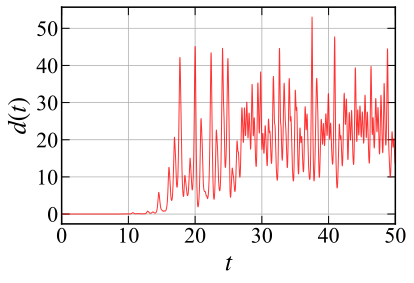

In [22]:
# Plot d(t) [0<t<T]
fig_d12, ax = plt.subplots(figsize=(6,4))
ax.plot(t, d12,'r-',lw=1,alpha=0.8)
ax.set_xlabel('$t$')
ax.set_ylabel('$d(t)$')
ax.set_yticks(np.arange(0,60,10))
ax.grid()
ax.set_xlim(0,T)
# plt.savefig('FIGS/LE-d12.pdf')
plt.show()

<IPython.core.display.Latex object>

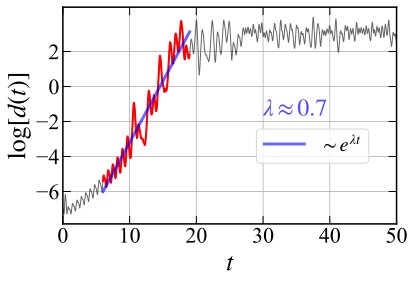

In [23]:
# Plot log[d(t)] [0<t<T]
t1=int(6/dt); t2=int(19/dt)

# calculate Lyapunov exponent
def logd_fit(x,a,b):
    return a*x+b 
params = curve_fit(logd_fit,t[t1:t2],np.log(d12[t1:t2]))
a0,b0 = params[0]
display(Latex('$\lambda = {}$'.format(np.round(a0,4))))

# plot log[d(t)]
fig_log_d12, ax = plt.subplots(figsize=(6,4))
ax.plot(t, np.log(d12),'k-',lw=1,alpha=0.6)
ax.plot(t[t1:t2], np.log(d12[t1:t2]),'r-',lw=2,alpha=1)
ax.plot(t[t1:t2],logd_fit(t[t1:t2],a0,b0),'b-',lw=3,alpha=0.6,label='$\sim e^{\lambda t}$')
ax.set_xlabel('$t$', fontsize=26)
ax.set_ylabel('$\log[d(t)]$', fontsize=26)
ax.set_yticks(np.arange(-6,4,2))
ax.grid()
ax.legend(fontsize=20,framealpha=0.8,loc=(0.58,0.28)) 
ax.set_xlim(0,T)
ax.text(0.6,0.5,r'$\lambda\approx 0.7$',fontsize=24,color='b',alpha=0.7,transform=ax.transAxes)
# plt.savefig('FIGS/LE-log_d12.pdf')
plt.show()

interactive(children=(FloatSlider(value=0.0, description='t1', max=50.0, step=0.2), IntSlider(value=45, descri…

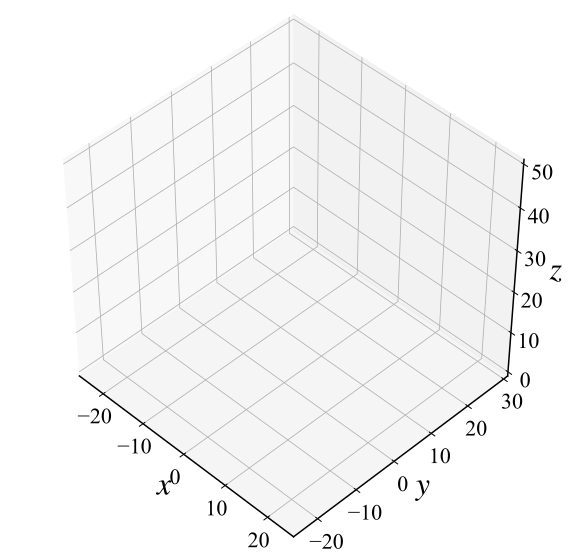

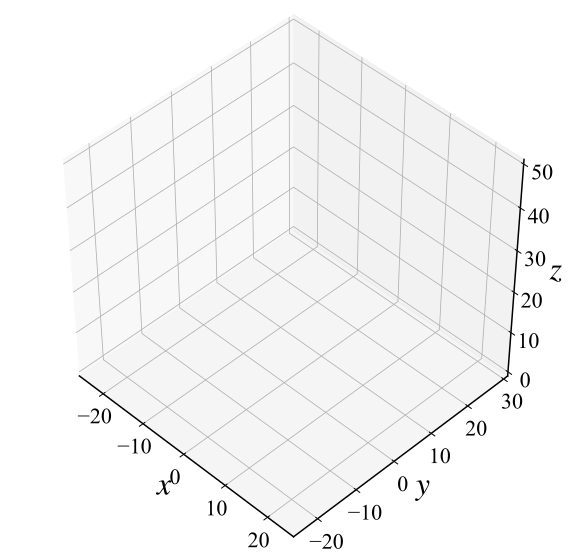

In [24]:
# Interactive plot of the 3D trajectory for 0<t<T
@interact(t1=(0,T,0.2),elev=(0,90,5),azim=(0,360,5))
def update(t1=0,elev=45,azim=315):
    fig, ax = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':'3d'})
    ax.set_xlim(-25,25)
    ax.set_ylim(-25,30)
    ax.set_zlim(0,50)
    ax.grid('major')
    ax.set_xlabel('$x$', fontsize=32)
    ax.set_ylabel('$y$', fontsize=32)
    ax.set_zlabel('$z$', fontsize=32);
    ax.view_init(elev,azim)
    ti = np.int(t1/dt)
    ax.plot(xyz[:ti,0],xyz[:ti,1],xyz[:ti,2],'r',alpha=0.6)
    ax.plot(xyz[ti,0],xyz[ti,1],xyz[ti,2],'o',ms=10,mfc='k')

## 9.4 Lorenz Map

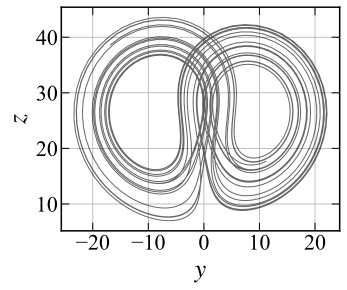

In [25]:
# Plot the y-z projection of the 3D trajectory [0<t<25]
t0 = int(25/dt)
fig_xz, ax = plt.subplots(figsize=(5,5))
ax.plot( xyz[t0:,1],xyz[t0:,2],'k-',lw=1,alpha=0.6)
# ax.plot(xyz1[t0:,0],xyz1[t0:,2],'b-',alpha=0.6)
ax.set_aspect('equal')
ax.set_xlabel('$y$')
ax.set_ylabel('$z$')
ax.set_xticks(np.arange(-20,25,10))
ax.grid()
# plt.savefig('FIGS/LE-yz.pdf')
plt.show()

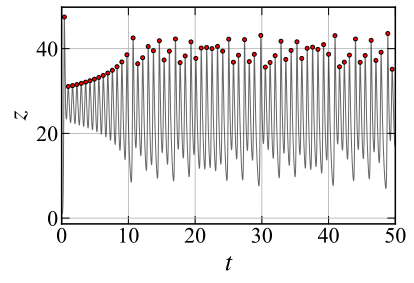

In [26]:
# Plot the z-t [0<t<T]
fig_zt, ax = plt.subplots(figsize=(6,4))
ax.plot(t, xyz[:,2],'k-',lw=1,alpha=0.6)

t_n,_ = find_peaks(xyz[:,2],height=0)
z_n = xyz[:,2][t_n]
ax.plot(t_n*dt,z_n,'o',ms=4,mfc='r',mec='k')

ax.set_xlabel('$t$')
ax.set_ylabel('$z$')
ax.grid()
ax.set_xlim(0,T)
# plt.savefig('FIGS/LE-zt.pdf')
plt.show()

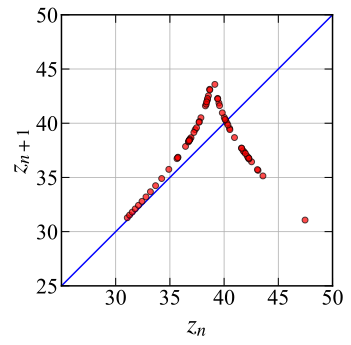

In [27]:
# Lorenz Map: z_(n+1)=f(z_n)
z1=25; z2=50; 
zz = np.linspace(z1,z2,10)

fig_LM, ax = plt.subplots(figsize=(5,5))
ax.plot(zz,zz,'b-')
ax.plot(z_n[:-1],z_n[1:],'o',ms=6,mfc='r',mec='k',alpha=0.7)
ax.set_xlabel('$z_n$')
ax.set_ylabel('$z_{n+1}$')
ax.set_aspect('equal')
ax.set_xlim(z1,z2)
ax.set_ylim(z1,z2)
ax.set_xticks(np.arange(z1,z2,5)+5)
ax.grid()
# plt.savefig('FIGS/LE-LM.pdf')
plt.show()

## Transient Chaos  [$\sigma=10$, $b=8/3$, $r=21$]

In [28]:
# set parameter values
s0, r0, b0 = 10, 21, 8/3
r_H = s0*(s0+b0+3)/(s0-b0-1)
c0 = np.sqrt(b0*(r0-1))
Cp0= [c0,c0,r0-1]; Cm0=[-c0,-c0,r0-1]
print('r_H = ',np.round(r_H,2),'>',r0)
print('C_+ = ',np.round(Cp0,2),';  C_- = ',np.round(Cm0,2))
# define duration (T) and time-step (dt) and initial conditions (xyz0)
T=60; dt=0.01
# Choice of the IC is very important!
xyz0 = [20,-5,5]

r_H =  24.74 > 21
C_+ =  [ 7.3  7.3 20. ] ;  C_- =  [-7.3 -7.3 20. ]


In [29]:
# Integrate numerically the LE 
t, xyz = txyz_LE(s0,r0,b0,T,dt,xyz0)

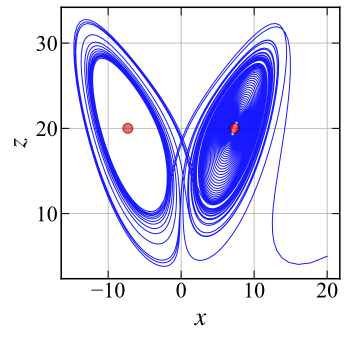

In [30]:
# Plot the x-z projection of the 3D trajectory [0<t<T]
t0 = int(0/dt)
fig_xz, ax = plt.subplots(figsize=(5,5))
ax.plot( xyz[t0:,0],xyz[t0:,2],'b-',lw=1,alpha=0.9)
ax.plot(Cp0[0],Cp0[2],'o',ms=10,mec='k',mfc='r',alpha=0.6)
ax.plot(Cm0[0],Cm0[2],'o',ms=10,mec='k',mfc='r',alpha=0.6)
# ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
ax.grid()
# plt.savefig('FIGS/LE-xz.pdf')
plt.show()

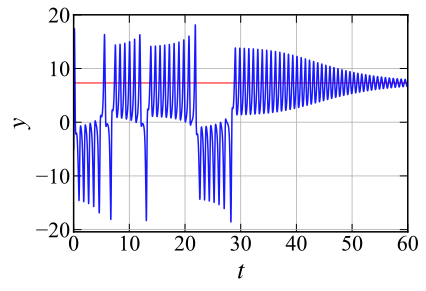

In [31]:
# Plot the y-t [0<t<T]
fig_yt, ax = plt.subplots(figsize=(6,4))
ax.plot(t, xyz[:,1],'b-',alpha=0.9)
ax.hlines(Cp0[1],0,T,color='r',lw=1)
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
ax.set_xticks(np.arange(0,70,10))
ax.set_yticks(np.arange(-20,25,10))
ax.grid()
ax.set_xlim(0,T)
# plt.savefig('FIGS/LE-yt.pdf')
plt.show()

## LE has a globally attractive LC for $r>313$!     [$\sigma=10$, $b=8/3$, $r=350$]

In [32]:
# set parameter values
s0, r0, b0 = 10, 350, 8/3
r_H = s0*(s0+b0+3)/(s0-b0-1)
c0 = np.sqrt(b0*(r0-1))
Cp0= [c0,c0,r0-1]; Cm0=[-c0,-c0,r0-1]
print('r_H = ',np.round(r_H,2),'<',r0)
print('C_+ = ',np.round(Cp0,2),';  C_- = ',np.round(Cm0,2))
# define duration (T) and time-step (dt) and initial conditions (xyz0)
T=25; dt=0.002
# Choice of the IC is very important!
# xyz0 = [20,-5,5]
xyz0 = [-20,1,500]

r_H =  24.74 < 350
C_+ =  [ 30.51  30.51 349.  ] ;  C_- =  [-30.51 -30.51 349.  ]


In [33]:
# Integrate numerically the LE 
t, xyz = txyz_LE(s0,r0,b0,T,dt,xyz0)

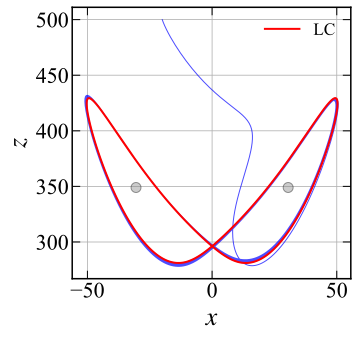

In [34]:
# Plot the x-z projection of the 3D trajectory [0<t<T]
t0 = int(20/dt)
fig_xz, ax = plt.subplots(figsize=(5,5))
ax.plot( xyz[:,0],xyz[:,2],'b-',lw=1,alpha=0.7)
ax.plot( xyz[t0:,0],xyz[t0:,2],'r-',lw=2,alpha=1,label='LC')
ax.plot(Cp0[0],Cp0[2],'o',ms=10,mec='k',mfc='gray',alpha=0.4)
ax.plot(Cm0[0],Cm0[2],'o',ms=10,mec='k',mfc='gray',alpha=0.4)
# ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
ax.legend()
ax.grid()
# plt.savefig('FIGS/LE-xz.pdf')
plt.show()

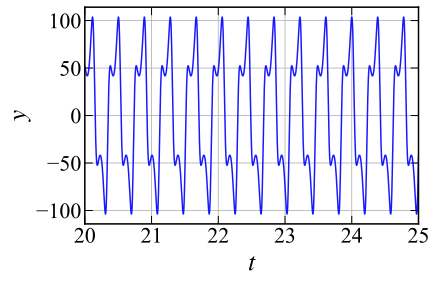

In [35]:
# Plot the y-t [t0<t<T]
fig_yt, ax = plt.subplots(figsize=(6,4))
ax.plot(t[t0:], xyz[t0:,1],'b-',alpha=0.9)

ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
# ax.set_xticks(np.arange(0,70,10))
ax.set_yticks(np.arange(-100,125,50))

ax.grid()
ax.set_xlim(int(t0*dt),T)

# plt.savefig('FIGS/LE-yt.pdf')
plt.show()